<a href="https://colab.research.google.com/github/taliaa21/surface_water_hydrology/blob/main/time_series_SST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Analysis of SST

### Import Libraries

In [ ]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
!pip install netCDF4
import netCDF4 as nc4

     |████████████████████████████████| 4.7MB 6.1MB/s 
     |████████████████████████████████| 317kB 31.9MB/s 


### Import Data

Get Cobe SST monthly dataset (1/16/1880-12/16/2018): https://psl.noaa.gov/data/gridded/data.cobe.html

In [ ]:
# Get data from below website
!wget http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc
#!wget ftp://ftp.cdc.noaa.gov/Datasets/COBE/sst.mon.mean.nc
#!wget ftp://ftp.cdc.noaa.gov/Datasets/COBE/sst.mon.ltm.1981-2010.nc

--2021-05-03 19:32:04--  http://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc
Resolving portal.nersc.gov (portal.nersc.gov)... 128.55.206.111, 128.55.206.110, 128.55.206.106, ...
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.206.111|:80... connected.
HTTP request sent, awaiting response... 308 Permanent Redirect
Location: https://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc [following]
--2021-05-03 19:32:04--  https://portal.nersc.gov/project/dasrepo/AGU_ML_Tutorial/sst.mon.mean.trefadj.anom.1880to2018.nc
Connecting to portal.nersc.gov (portal.nersc.gov)|128.55.206.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 432481041 (412M) [application/x-netcdf]
Saving to: ‘sst.mon.mean.trefadj.anom.1880to2018.nc’

sst.mon.mean.trefad 100%[===================>] 412.45M  32.2MB/s    in 14s     

2021-05-03 19:32:19 (29.7 MB/s) - ‘sst.mon.mean.trefadj.anom.1880to2018.nc’ s

Create xarray dataset of data

In [ ]:
# Create netCDF4 file
file_name = "sst.mon.mean.trefadj.anom.1880to2018.nc"
ncf_ds = nc4.Dataset(file_name)

In [ ]:
# Convert to xarray dataset
store = xr.backends.NetCDF4DataStore(ncf_ds)
ds = xr.open_dataset(store)

Create dataframe of training data (1980-2006) for Half Moon Bay (lat: 37.5, lon: -122.5)

In [ ]:
# Convert to dataframe
df_train = ds.sel(time=slice('1980-01-01','2006-12-31')).to_dataframe().reset_index()
# Fill nan values of SST with zero
df_train.loc[:, 'sst'] = df_train.loc[:, 'sst'].fillna(0)
# Select Half Moon Bay location
df_train = df_train[(df_train.lat == 37.5) & (df_train.lon == 360+(-122.5))][['time', 'sst']].reset_index(drop = True)
df_train

,time,sst
0,1980-01-16 12:00:00,0.727098
1,1980-02-16 12:00:00,0.669677
2,1980-03-16 12:00:00,0.668935
3,1980-04-16 12:00:00,0.300903
4,1980-05-16 12:00:00,0.008451
...,...,...
319,2006-08-16 12:00:00,0.083806
320,2006-09-16 12:00:00,-0.654871
321,2006-10-16 12:00:00,0.040130
322,2006-11-16 12:00:00,0.167484


Create dataframe of test data (2007-2017) for Half Moon Bay (lat: 37.5, lon: -122.5)

In [ ]:
# Convert to dataframe
df_test = ds.sel(time=slice('2007-01-01','2017-12-31')).to_dataframe().reset_index()
# Fill nan values of SST with zero
df_test.loc[:, 'sst'] = df_test.loc[:, 'sst'].fillna(0)
# Select Half Moon Bay location
df_test = df_test[(df_test.lat == 37.5) & (df_test.lon == 360+(-122.5))][['time', 'sst']].reset_index(drop = True)
df_test

,time,sst
0,2007-01-16 12:00:00,-0.602903
1,2007-02-16 12:00:00,-0.250323
2,2007-03-16 12:00:00,-0.680065
3,2007-04-16 12:00:00,-0.775097
4,2007-05-16 12:00:00,-0.745549
...,...,...
127,2017-08-16 12:00:00,0.473806
128,2017-09-16 12:00:00,0.815129
129,2017-10-16 12:00:00,-0.459870
130,2017-11-16 12:00:00,0.858484


Plot of test and train data for Half Moon Bay


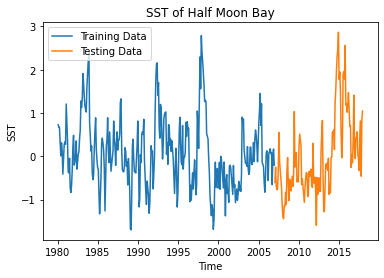

In [ ]:
plt.plot(df_train['time'], df_train['sst'], label = 'Training Data')
plt.plot(df_test['time'], df_test['sst'], label = 'Testing Data')
plt.xlabel('Time')
plt.ylabel('SST')
plt.title('SST of Half Moon Bay')
plt.legend();

### Build Time Series Models

#### 1) Triple Exponential Smoothing (TES) Model

In [ ]:
# Import model
from statsmodels.tsa.holtwinters import ExponentialSmoothing

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



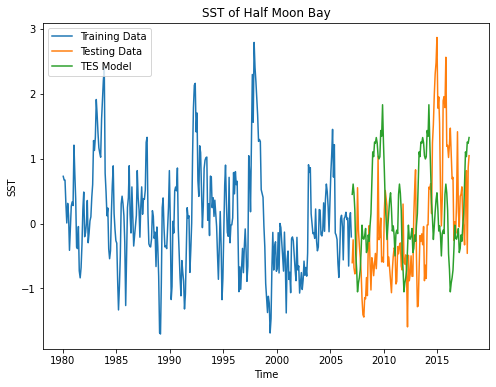

In [ ]:
# Initialize triple exponential smoothing model
tes_model = ExponentialSmoothing(df_train.sst, trend = None, seasonal = 'add', seasonal_periods = 52)
# Fit model
tes_fit = tes_model.fit(optimized = True)
# Forecast for 2007-2017
tes_pred = tes_fit.forecast(len(df_test.sst)).reset_index(drop=True)
# Plot model
plt.figure(figsize=(8, 6))
plt.plot(df_train.time, df_train.sst, label = 'Training Data')
plt.plot(df_test.time, df_test.sst, label = 'Testing Data')
plt.plot(df_test.time, tes_pred, label = 'TES Model')
plt.xlabel('Time')
plt.ylabel('SST')
plt.title('SST of Half Moon Bay')
plt.legend();

#### 2) Seasonal Autoregressive Integrated Moving Average (SARIMA) Model

In [ ]:
# Import model
from statsmodels.tsa.statespace.sarimax import SARIMAX

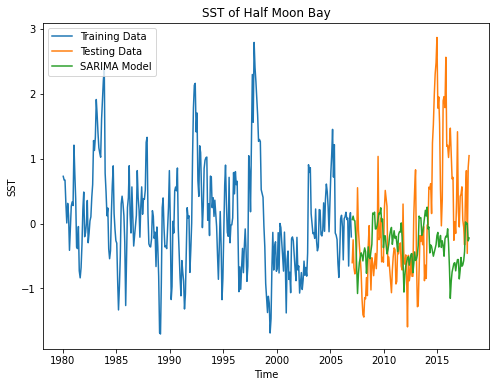

In [ ]:
# Initialize triple exponential smoothing model
sarima_model = SARIMAX(df_train.sst, order=(1,1,1), seasonal_order=(1,1,1,52))
# Fit model
sarima_fit = sarima_model.fit()
# Forecast for 2007-2017
sarima_pred = sarima_fit.forecast(len(df_test.sst)).reset_index(drop=True)
# Plot model
plt.figure(figsize=(8, 6))
plt.plot(df_train.time, df_train.sst, label = 'Training Data')
plt.plot(df_test.time, df_test.sst, label = 'Testing Data')
plt.plot(df_test.time, sarima_pred, label = 'SARIMA Model')
plt.xlabel('Time')
plt.ylabel('SST')
plt.title('SST of Half Moon Bay')
plt.legend();

#### 3) Prophet Model

In [ ]:
# Import model
from fbprophet import Prophet

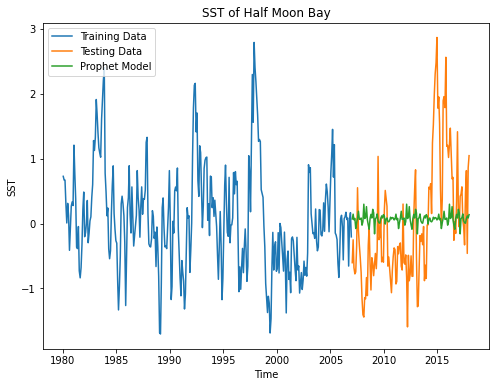

In [ ]:
# Prophet requires the time series to be a 2 column pd.dataframe with the Date as 'ds' and the values as 'y'.
df_prohpet = df_train.rename(columns = {'time':'ds', 'sst':'y'})
# Initialize Prophet model
prophet_model = Prophet(weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=True, growth='flat')
# Fit the model on the time series
prophet_model.fit(df_prohpet)
# Create a DataFrame of future dates to create forecasts for
prophet_pred_time = prophet_model.make_future_dataframe(periods=len(df_test.sst), freq = 'MS', include_history = False) + pd.DateOffset(days=15)
# Use the model to create forecasts
prophet_pred = prophet_model.predict(prophet_pred_time)
# Plot model
plt.figure(figsize=(8, 6))
plt.plot(df_train.time, df_train.sst, label = 'Training Data')
plt.plot(df_test.time, df_test.sst, label = 'Testing Data')
plt.plot(prophet_pred.ds, prophet_pred.yhat, label = 'Prophet Model')
plt.xlabel('Time')
plt.ylabel('SST')
plt.title('SST of Half Moon Bay')
plt.legend();

#### 4) Model Metrics Comparison

In [ ]:
# Import metrics functions
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import mean_squared_error

# Define MAPE function
def mape(actual, pred):
    mape = np.mean(np.abs((actual - pred)/actual))*100
    return mape

# Metrics function
def metrics(actual, pred, model_name):
  print('------', model_name, ' Model------')
  print("R2: ", np.round(r2_score(actual, pred), 4))
  print("MAE: ", np.round(mean_absolute_error(actual, pred), 4))
  print("MAPE: ", np.round(mape(actual, pred), 4))
  print("MSE: ", np.round(mean_squared_error(actual, pred), 4))

In [ ]:
# Metrics of TES Model
metrics(df_test.sst, tes_pred, 'TES')

------ TES  Model------
R2:  -0.654
MAE:  1.0049
MAPE:  316.2973
MSE:  1.4152


In [ ]:
# Metrics of SARIMA Model
metrics(df_test.sst, sarima_pred, 'SARIMA')

------ SARIMA  Model------
R2:  -0.2889
MAE:  0.8003
MAPE:  186.4918
MSE:  1.1029


In [ ]:
# Metrics of Prophet Model
metrics(df_test.sst, prophet_pred.yhat, 'Prophet')

------ Prophet  Model------
R2:  -0.0078
MAE:  0.7561
MAPE:  114.3487
MSE:  0.8624


### Forecast into the Future 10 Years

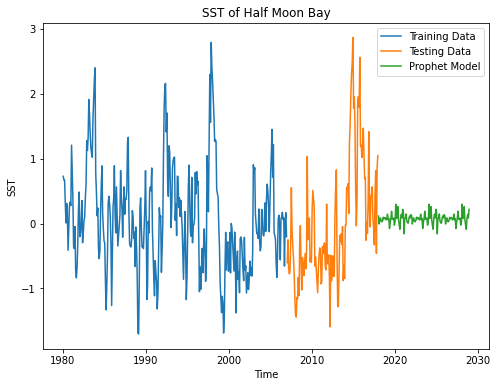

In [ ]:
# Create a DataFrame of future dates to create forecasts for
future = prophet_pred_time + pd.DateOffset(years=11)
# Use the model to create forecasts
prophet_pred_future = prophet_model.predict(future)
# Plot model
plt.figure(figsize=(8, 6))
plt.plot(df_train.time, df_train.sst, label = 'Training Data')
plt.plot(df_test.time, df_test.sst, label = 'Testing Data')
plt.plot(prophet_pred_future.ds, prophet_pred_future.yhat, label = 'Prophet Model')
plt.xlabel('Time')
plt.ylabel('SST')
plt.title('SST of Half Moon Bay')
plt.legend();